In [3]:
import numpy as np
from numpy.linalg import matrix_power
import random
import itertools
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from scipy.optimize import minimize
import networkx as nx
from scipy import sparse
import osqp
from read_code import read_code

In [29]:
def cyclic_shift_matrix(l):
    arr = np.eye(l)
    return np.roll(arr, axis=1, shift=1)

ell = 12
m = 12

x = np.kron(cyclic_shift_matrix(ell), np.eye(m))
y = np.kron(np.eye(ell), cyclic_shift_matrix(m))

A = matrix_power(x, 3) + matrix_power(y, 2) + matrix_power(y, 7)
B = matrix_power(y, 3) + matrix_power(x, 1) + matrix_power(x, 2)

Hx = np.hstack([A, B])
Hz = np.hstack([B.T, A.T])

H = np.vstack([Hx, Hz])

n = H.shape[1]
m = H.shape[0]

In [30]:
# Tanner graph
# G = nx.Graph()
# G.add_nodes_from(np.arange(n+m))

# for i in range(n):
#     G.nodes[i]['type'] = 'k'

# for i in range(m):
#     if (np.count_nonzero(H[i]) == r): # Z checks
#         G.nodes[i+n]['type'] = 'r'  
#     else: # X checks
#         G.nodes[i+n]['type'] = 'b'    

# for i in range(m):
#     for j in range(n):
#         if H[i][j]: 
#             G.add_edge(j, i+n)

# n = n+m

# edge_matrix = np.zeros((G.number_of_edges(), G.number_of_nodes()))
# for i, e in enumerate(G.edges()):
#     edge_matrix[i][e[0]] = 1
#     edge_matrix[i][e[1]] = -1 

# P = edge_matrix.T @ edge_matrix
# P = sparse.csc_matrix(P)

In [31]:
# connectivity graph
G = nx.Graph()
for i in np.arange(n):
    G.add_node(i)
    G.nodes[i]['type'] = 'k'

G.remove_edges_from(G.edges())

for i in range(m):
    checks = np.where(H[i])[0]
    # c = 1 if i in bg_inds else 10
    for pair in itertools.combinations(checks, 2):
        G.add_edge(pair[0], pair[1], c=1)

edge_matrix = np.zeros((G.number_of_edges(), G.number_of_nodes()))
for i, e in enumerate(G.edges(data=True)):
    edge_matrix[i][e[0]] = e[2]['c']
    edge_matrix[i][e[1]] = -e[2]['c'] # so make this bigger (but same) if you want to prioritize an edge

P = edge_matrix.T @ edge_matrix
P = sparse.csc_matrix(P)

In [32]:
def print_graph(G, edges=False):
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    lines = []
    xs = []
    ys = []
    cs = []
    
    for i in range(G.number_of_nodes()):
        v = G.nodes[i]
        xs.append(v['x'])
        ys.append(v['y'])
        cs.append(v['type'])
        for nbr in G.neighbors(i):
            lines.append([(v['x'], v['y']), (G.nodes[nbr]['x'], G.nodes[nbr]['y'])])

    pts = itertools.product(np.arange(max(xs)+1), np.arange(max(ys)+1))
    # pts = itertools.product(np.arange(int(5*np.sqrt(n))), np.arange(int(5*np.sqrt(n))))

    plt.scatter(*zip(*pts), s=3, c='k')
    plt.scatter(xs, ys, s=20, c=cs)

    if (edges):
        lc = mc.LineCollection(lines, colors='k', linewidth=1)
        ax.add_collection(lc)
    # ax.axis('off')
    plt.show()

pos = np.array([[{'x':i,'y':j} for i in range(int(5*np.sqrt(n)))] for j in range(int(5*np.sqrt(n)))]).flatten()
grid = np.array([[0 for i in range(int(5*np.sqrt(n)))] for j in range(int(5*np.sqrt(n)))])

In [33]:
def find_nearest_available(x, y):
    n = len(grid[0])
    visited = np.zeros((n,n))

    queue = [(x, y)]
    for _ in range(n**2):
        x, y = queue.pop(0)
        
        if (not grid[x][y]):
            return (x, y)
        
        pot_nbrs = [(x, y+1), (x, y-1), (x+1, y), (x-1, y)]
        for nbr in pot_nbrs:
            new_x, new_y = nbr
            if ((0 <= new_x < n) and (0 <= new_y < n)):
                if (not visited[new_x][new_y]):
                    queue.append(nbr)
                    visited[new_x][new_y] = True


def points_with_manhattan_distance(p, d):
    n = len(grid[0])
    result = []
    for i in range(-d, d+1):
        for j in range(-d, d+1):
            new_x, new_y = (p[0]+i, p[1]+j)
            if ((manhattan(p, (new_x, new_y)) <= d)
                and (0 <= new_x < n) and (0 <= new_y < n) and (not grid[new_x][new_y])):
                result.append((new_x, new_y))
    return result


# def swap_nodes(p):
#     print(p)
#     n = len(grid[0])
#     x, y = p
#     v1 = grid[x][y]
#     pot_nbrs = [(x, y+1), (x, y-1), (x+1, y), (x-1, y)]
#     for nbr in pot_nbrs:
#         new_x, new_y = nbr
#         if ((0 <= new_x < n) and (0 <= new_y < n) and (grid[new_x][new_y])):
#             v2 = grid[new_x][new_y]

#             if (v1.tot_edge_len(p) + v2.tot_edge_len(nbr) > v1.tot_edge_len(nbr) + v2.tot_edge_len(p)):
#                 v1.x = new_x
#                 v1.y = new_y
#                 v2.x = x
#                 v2.y = y
#                 grid[x][y] = v2
#                 grid[new_x][new_y] = v1



def compact(dir, gamma):
    def S(dir):
        edges = []
        for i in range(len(grid[0])):
            if (dir): # horizontal
                nodes = np.where(grid[:,i])[0]
                for j in range(len(nodes)-1):
                    edges.append((grid[nodes[j]][i]-1, grid[nodes[j+1]][i]-1))
            else: # vertical
                nodes = np.where(grid[i])[0]
                for j in range(len(nodes)-1):
                    edges.append((grid[i][nodes[j]]-1, grid[i][nodes[j+1]]-1))
        return edges
    
    def fun(x):
        # x is a list of x (y) coordinates of the nodes
        return sum([(x[edge[0]] - x[edge[1]])**2 for edge in G.edges()]) #maybe abs value
    
    x = [v[1]['x'] for v in G.nodes(data=True)] if dir else [v[1]['y'] for v in G.nodes(data=True)]
    vis_edges = S(dir)

    res = minimize(fun, x0=x, method="SLSQP", 
                   constraints=[{'type': 'ineq', 'fun': lambda x, e=e: x[e[1]] - x[e[0]] - gamma} for e in vis_edges],
                   bounds=[(0, len(grid[0])-1) for _ in range(len(x))])

    for i, p in enumerate((res.x).astype(int)):
        v = G.nodes[i]
        if (dir):
            v['x'] = p
        else:
            v['y'] = p


def compact_osqp(dir, gamma):
    def S(dir, gamma):
        edges = []
        for i in range(len(grid[0])):
            if (dir): # horizontal
                nodes = np.where(grid[:,i])[0]
                gamma_p = min(gamma, len(grid[0])//len(nodes)) if len(nodes) else 0
                for j in range(len(nodes)-1):
                    edges.append((grid[nodes[j]][i]-1, grid[nodes[j+1]][i]-1, gamma_p))
            else: # vertical
                nodes = np.where(grid[i])[0]
                gamma_p = min(gamma, len(grid[0])//len(nodes)) if len(nodes) else 0
                for j in range(len(nodes)-1):
                    edges.append((grid[i][nodes[j]]-1, grid[i][nodes[j+1]]-1, gamma_p))
        return edges
    
    vis = S(dir, gamma)

    A1 = np.zeros((len(vis), G.number_of_nodes()))
    l1 = np.zeros(len(vis))

    for i, e in enumerate(vis):
        A1[i][e[1]] = 1
        A1[i][e[0]] = -1
        l1[i] = e[2]

    A2 = np.eye(G.number_of_nodes())
    l2 = np.zeros(G.number_of_nodes())

    A = np.vstack([A1, A2])
    l = np.concatenate([l1, l2])
    u = np.full(len(vis) + G.number_of_nodes(), int(5*np.sqrt(n))-1)
    
    q = np.zeros(G.number_of_nodes())
    A = sparse.csc_matrix(A)
    l = l
    u = u

    prob = osqp.OSQP()
    prob.setup(P, q, A, l, u, alpha=1.0, verbose=False)
    res = prob.solve()
    
    for i, p in enumerate((res.x).astype(int)):
        v = G.nodes[i]
        if (dir):
            v['x'] = p
        else:
            v['y'] = p


def manhattan(p1, p2):
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

def tot_edge_len(v, p):
    return sum([manhattan(p, (G.nodes[nbr]['x'], G.nodes[nbr]['y'])) for nbr in G.neighbors(v)])

In [34]:
grid = np.array([[0 for i in range(int(5*np.sqrt(n)))] for j in range(int(5*np.sqrt(n)))])

def random_init_pos():
    initial_pos = random.sample(list(pos), n)
    for i in range(n):
        pt = (initial_pos[i]['x'], initial_pos[i]['y'])
        G.nodes[i]['x'] = pt[0]
        G.nodes[i]['y'] = pt[1]
        grid[pt[0]][pt[1]] = i+1

# def bfs_init():
placed = [0]
pt = (int(5*np.sqrt(n)/2), int(5*np.sqrt(n)/2))
G.nodes[0]['x'] = pt[0]
G.nodes[0]['y'] = pt[1]
grid[pt[0]][pt[1]] = 1
bfs_tree = list(nx.bfs_tree(G, 0))

for v in bfs_tree[1:]:
    pot_locs = points_with_manhattan_distance((G.nodes[placed[-1]]['x'], G.nodes[placed[-1]]['y']), int(np.sqrt(n)))
    dist = np.inf
    for pot_loc in pot_locs:
        tmp_dist = sum([manhattan(pot_loc, (G.nodes[nbr]['x'], G.nodes[nbr]['y'])) for nbr in G.neighbors(v) if nbr in placed])
        if (tmp_dist < dist):
            dist = tmp_dist
            new_x, new_y = pot_loc
    
    G.nodes[v]['x'] = new_x
    G.nodes[v]['y'] = new_y
    grid[new_x][new_y] = v+1
    placed.append(v)

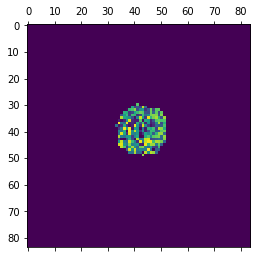

In [35]:
plt.matshow(grid)

In [36]:
iters = int(20*np.sqrt(n))
T = 0.2*int(np.sqrt(n))
k = (0.2/T)**(1/iters)
compactDir = True

for i in range(iters//2):
    print(i, iters//2)
    for j in range(G.number_of_nodes()):
        if (list(G.neighbors(j))):
            nbrMedX = np.median([G.nodes[v]['x'] for v in G.neighbors(j)])
            nbrMedY = np.median([G.nodes[v]['y'] for v in G.neighbors(j)])

            v = G.nodes[j]
            x = int(min(max(nbrMedX + random.uniform(-T, T), 0), int(5*np.sqrt(n))-1))
            y = int(min(max(nbrMedY + random.uniform(-T, T), 0), int(5*np.sqrt(n))-1))

            new_x, new_y = find_nearest_available(x, y)
            d = manhattan((x,y), (new_x, new_y))
            pot_locs = points_with_manhattan_distance((new_x, new_y), d+1)

            dist = np.inf
            for pot_loc in pot_locs:
                tmp_dist = tot_edge_len(j, (pot_loc[0], pot_loc[1]))
                if (tmp_dist < dist):
                    dist = tmp_dist
                    new_x, new_y = pot_loc

            if ((v['x'], v['y']) == (new_x, new_y)):
                print("should swap")
            if (tot_edge_len(j, (new_x, new_y)) < tot_edge_len(j, (v['x'], v['y']))):
                grid[v['x']][v['y']] = 0
                v['x'] = new_x
                v['y'] = new_y
                grid[new_x][new_y] = j+1

    if (i % 3 == 0):
        compact_osqp(compactDir, 3)
        compactDir = not compactDir

        grid = np.array([[0 for i in range(int(5*np.sqrt(n)))] for j in range(int(5*np.sqrt(n)))])

        for j in range(G.number_of_nodes()):
            grid[G.nodes[j]['x']][G.nodes[j]['y']] = j+1

    T *= k

compact_osqp(True, 3)
grid = np.array([[0 for i in range(int(5*np.sqrt(n)))] for j in range(int(5*np.sqrt(n)))])

for j in range(G.number_of_nodes()):
    grid[G.nodes[j]['x']][G.nodes[j]['y']] = j+1
compact_osqp(False, 3)
grid = np.array([[0 for i in range(int(5*np.sqrt(n)))] for j in range(int(5*np.sqrt(n)))])

for j in range(G.number_of_nodes()):
    grid[G.nodes[j]['x']][G.nodes[j]['y']] = j+1

    

for i in range(iters//2+1):
    print(i, iters//2+1)
    for j in range(G.number_of_nodes()):
        if (list(G.neighbors(j))):
            nbrMedX = np.median([G.nodes[v]['x'] for v in G.neighbors(j)])
            nbrMedY = np.median([G.nodes[v]['y'] for v in G.neighbors(j)])

            v = G.nodes[j]
            x = int(min(max(nbrMedX + random.uniform(-T, T), 0), int(5*np.sqrt(n))-1))
            y = int(min(max(nbrMedY + random.uniform(-T, T), 0), int(5*np.sqrt(n))-1))

            new_x, new_y = find_nearest_available(x, y)
            d = manhattan((x,y), (new_x, new_y))
            pot_locs = points_with_manhattan_distance((new_x, new_y), d+1)

            dist = np.inf
            for pot_loc in pot_locs:
                tmp_dist = tot_edge_len(j, (pot_loc[0], pot_loc[1]))
                if (tmp_dist < dist):
                    dist = tmp_dist
                    new_x, new_y = pot_loc

            if ((v['x'], v['y']) == (new_x, new_y)):
                print("should swap2")
            if (tot_edge_len(j, (new_x, new_y)) < tot_edge_len(j, (v['x'], v['y']))):
                grid[v['x']][v['y']] = 0
                v['x'] = new_x
                v['y'] = new_y
                grid[new_x][new_y] = j+1

    if (i % 3 == 0):
        compact_osqp(compactDir, max(1, 1+(2*(iters//2-i-30)/(0.5*iters))))
        compactDir = not compactDir

        grid = np.array([[0 for i in range(int(5*np.sqrt(n)))] for j in range(int(5*np.sqrt(n)))])

        for j in range(G.number_of_nodes()):
            grid[G.nodes[j]['x']][G.nodes[j]['y']] = j+1

    T *= k

0 169
1 169
2 169
3 169
4 169
5 169
6 169
7 169
8 169
9 169
10 169
11 169
12 169
13 169
14 169
15 169
16 169
17 169
18 169
19 169
20 169
21 169
22 169
23 169
24 169
25 169
26 169
27 169
28 169
29 169
30 169
31 169
32 169
33 169
34 169
35 169
36 169
37 169
38 169
39 169
40 169
41 169
42 169
43 169
44 169
45 169
46 169
47 169
48 169
49 169
50 169
51 169
52 169
53 169
54 169
55 169
56 169
57 169
58 169
59 169
60 169
61 169
62 169
63 169
64 169
65 169
66 169
67 169
68 169
69 169
70 169
71 169
72 169
73 169
74 169
75 169
76 169
77 169
78 169
79 169
80 169
81 169
82 169
83 169
84 169
85 169
86 169
87 169
88 169
89 169
90 169
91 169
92 169
93 169
94 169
95 169
96 169
97 169
98 169
99 169
100 169
101 169
102 169
103 169
104 169
105 169
106 169
107 169
108 169
109 169
110 169
111 169
112 169
113 169
114 169
115 169
116 169
117 169
118 169
119 169
120 169
121 169
122 169
123 169
124 169
125 169
126 169
127 169
128 169
129 169
130 169
131 169
132 169
133 169
134 169
135 169
136 169
137 169
138 16

In [37]:
from mec import make_circle
rs = []

for i in range(H.shape[0]):
    pts = []
    qbts = np.where(H[i])[0]
    
    for qbt in qbts:
        pts.append((G.nodes[qbt]['x'], G.nodes[qbt]['y']))
    if (len(pts)):
        tup = (i, make_circle(pts)[2])
        print(tup)
        rs.append(tup)

(0, 4.146703879133943)
(1, 3.650808453872088)
(2, 3.5)
(3, 2.850438562747845)
(4, 6.020797289396147)
(5, 3.7267799624996503)
(6, 5.099019513592785)
(7, 3.2841014538830002)
(8, 5.522680508593631)
(9, 4.031128874149275)
(10, 3.400367627183861)
(11, 4.308597665230585)
(12, 4.119492882218417)
(13, 7.280109889280519)
(14, 4.693375946776241)
(15, 4.125395603925628)
(16, 6.031204898355847)
(17, 4.397782830831974)
(18, 2.1666666666666665)
(19, 4.273694281288422)
(20, 3.1622776601683795)
(21, 5.63205113613149)
(22, 4.609772228646444)
(23, 3.5459786374203417)
(24, 6.0827625302982185)
(25, 6.519202405202649)
(26, 2.6)
(27, 5.793645619619368)
(28, 5.099019513592785)
(29, 6.103277807866851)
(30, 5.024937810560445)
(31, 6.283490154421353)
(32, 5.0)
(33, 7.0710678118654755)
(34, 7.280109889280519)
(35, 5.70087712549569)
(36, 6.657946744128061)
(37, 6.609126686299451)
(38, 5.522680508593631)
(39, 6.367693511873591)
(40, 5.5)
(41, 5.656854249492381)
(42, 4.286021241920566)
(43, 6.166666666666667)
(44, 

(array([19., 26., 35., 34., 39., 34., 39., 23., 26., 13.]),
 array([2.        , 2.7275157 , 3.45503139, 4.18254709, 4.91006278,
        5.63757848, 6.36509417, 7.09260987, 7.82012556, 8.54764126,
        9.27515695]),
 <BarContainer object of 10 artists>)

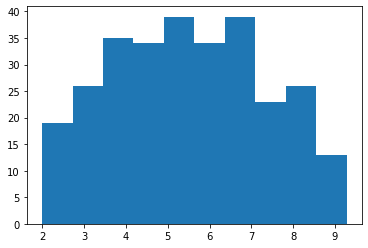

In [38]:
plt.hist([r[1] for r in rs])

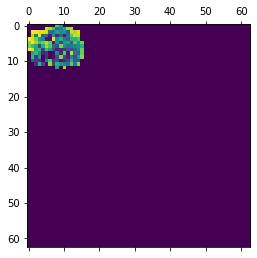

In [42]:
plt.matshow(grid)

In [43]:
rs.sort(key=lambda x: x[1])

In [44]:
iis = [r[0] for r in rs]
bg_inds = iis[int(0.7*len(rs)):]

In [48]:
# 180 normal
# inds = [(9,7),(7,8),(10,9),(10,10),(10,7),(11,7),(10,6),(8,6),(9,9),(7,5),(11,6),(9,2),(7,7),(5,10),(8,1),(12,5),(6,8),(3,7),(4,8),(4,7),(12,4),(11,10),(9,8),(7,2),(4,9),(11,11),(7,5),(9,6),(12,11),(5,5),(10,2),(5,11),(8,7),(11,9),(12,10),(4,3),(10,3),(13,5),(8,9),(7,5),(12,6),(7,9),(10,8),(4,1),(11,5),(6,3),(7,10),(10,0),(13,3),(12,2),(13,4),(8,10),(7,4),(8,2),(6,4),(11,3),(14,3),(8,4),(7,11),(5,3),(6,7),(11,0),(14,2),(11,8),(9,4),(6,11),(7,8),(2,9),(4,6),(7,6),(5,7),(6,1),(7,3),(13,2),(14,4),(8,4),(6,10),(5,9),(2,7),(7,0),(5,8),(10,4),(15,5),(2,8),(1,8),(7,1),(6,6),(9,1),(11,2),(8,8),(12,3),(12,7),(5,2),(6,9),(13,10),(1,7),(10,1),(10,12),(6,0),(7,12),(5,1),(8,5),(3,3),(13,6),(9,11),(6,5),(12,8),(3,4),(10,11),(1,6),(12,1),(12,9),(3,2),(9,10),(14,6),(5,4),(4,5),(2,4),(15,4),(5,6),(8,11),(2,2),(13,1),(4,2),(9,0),(8,3),(10,5),(15,6),(3,8),(9,5),(9,12),(3,5),(4,10),(3,1),(11,1),(13,7),(13,8),(2,3),(3,9),(14,1),(9,3),(6,2),(11,4),(14,8),(14,5),(8,0),(4,4),(1,3),(14,7),(14,9),(1,4),(1,9),(13,9),(2,6),(3,6),(0,6),(0,7),(1,5),(2,10),(2,5)]
# 180 70%
inds = [(13,7),(13,8),(11,7),(10,8),(10,7),(12,8),(11,8),(12,6),(12,9),(13,6),(12,7),(12,5),(14,9),(15,8),(13,3),(2,7),(11,9),(16,7),(14,8),(17,6),(9,6),(9,9),(9,8),(7,2),(17,7),(7,8),(10,3),(8,7),(6,10),(9,3),(7,5),(17,8),(10,6),(10,9),(6,9),(9,2),(7,6),(11,6),(15,9),(9,4),(8,6),(11,10),(5,8),(10,2),(5,10),(12,3),(15,10),(12,4),(3,6),(5,4),(4,6),(17,9),(8,4),(13,2),(14,11),(4,4),(3,8),(11,4),(16,9),(12,2),(14,10),(5,3),(4,7),(10,10),(8,5),(18,8),(10,5),(14,7),(18,5),(7,4),(16,5),(11,2),(7,7),(2,5),(3,9),(10,4),(18,7),(9,7),(17,5),(7,1),(16,8),(1,5),(2,6),(14,6),(18,6),(8,2),(17,3),(14,3),(6,6),(8,8),(1,6),(2,9),(11,3),(16,10),(5,9),(16,4),(6,3),(7,9),(7,3),(5,7),(8,1),(9,5),(12,0),(2,8),(7,10),(8,3),(3,10),(17,4),(5,11),(15,5),(5,5),(4,8),(11,0),(6,7),(1,7),(16,2),(11,5),(11,1),(3,5),(17,2),(9,10),(10,1),(6,4),(9,1),(4,3),(8,0),(6,8),(6,5),(12,10),(18,2),(8,9),(16,3),(13,9),(12,1),(3,3),(0,7),(4,10),(13,1),(3,1),(5,6),(3,4),(14,2),(4,5),(3,7),(1,8),(9,0),(15,3),(13,0),(4,9),(0,8),(15,2),(15,6),(4,11),(13,5),(18,3),(14,5),(15,4),(14,4),(16,6),(13,4)]

# 360
# inds = [(6,5),(10,6),(9,5),(19,6),(17,7),(2,6),(12,7),(2,5),(2,7),(3,7),(1,5),(2,4),(1,6),(8,5),(6,13),(3,8),(11,8),(7,7),(10,5),(6,14),(3,4),(18,6),(17,9),(10,11),(8,6),(18,7),(16,7),(19,7),(18,8),(15,15),(19,9),(8,4),(14,9),(3,10),(16,8),(13,14),(18,5),(2,8),(1,8),(17,8),(14,12),(4,9),(15,10),(13,7),(19,8),(3,3),(1,7),(2,12),(6,8),(3,11),(4,8),(12,9),(17,6),(2,9),(4,4),(8,13),(20,9),(5,2),(1,9),(3,6),(3,5),(7,14),(19,10),(3,9),(6,6),(13,9),(17,10),(11,4),(6,15),(5,11),(7,15),(1,11),(5,5),(12,6),(21,10),(6,1),(2,10),(10,9),(8,15),(9,10),(7,5),(13,4),(5,15),(20,8),(11,6),(8,16),(5,10),(8,13),(1,12),(5,6),(14,4),(14,16),(20,11),(7,3),(1,10),(18,11),(15,18),(20,13),(16,11),(18,4),(7,11),(9,15),(6,11),(7,1),(13,2),(6,16),(20,12),(18,13),(15,16),(18,10),(15,7),(17,4),(16,9),(13,17),(6,4),(19,15),(15,19),(19,14),(14,8),(15,3),(4,16),(9,14),(13,10),(7,17),(6,3),(11,2),(5,16),(16,12),(3,12),(11,13),(3,15),(16,3),(19,17),(17,16),(17,15),(5,8),(16,2),(16,10),(15,17),(20,14),(6,7),(11,14),(9,11),(13,5),(5,12),(18,9),(17,12),(4,10),(13,15),(9,12),(11,7),(3,17),(17,2),(15,14),(16,15),(12,4),(20,10),(4,7),(12,5),(18,14),(17,19),(20,15),(9,6),(8,9),(2,14),(14,13),(6,10),(2,11),(5,4),(9,0),(8,11),(11,16),(13,12),(13,1),(1,13),(5,3),(18,15),(14,11),(0,12),(4,6),(4,11),(7,4),(19,12),(9,1),(4,5),(6,2),(8,2),(3,13),(0,13),(5,13),(8,8),(10,8),(11,15),(18,12),(7,10),(7,6),(8,1),(8,14),(2,15),(15,9),(14,1),(9,3),(0,14),(4,12),(20,16),(12,12),(4,14),(11,5),(9,16),(2,17),(8,17),(14,7),(6,9),(10,19),(13,3),(14,17),(4,18),(9,4),(13,11),(15,2),(14,5),(7,16),(12,11),(10,3),(10,13),(0,15),(16,13),(4,3),(9,8),(9,18),(8,10),(14,3),(12,3),(6,12),(2,16),(10,15),(13,8),(9,19),(5,18),(7,13),(15,6),(11,17),(14,6),(12,15),(3,18),(8,3),(15,12),(14,2),(17,3),(1,15),(14,15),(11,3),(11,11),(1,14),(16,14),(18,16),(11,19),(19,16),(10,10),(6,17),(19,18),(16,17),(15,5),(12,17),(11,10),(7,9),(12,2),(16,6),(17,18),(13,16),(15,4),(15,1),(8,7),(1,16),(18,19),(11,18),(16,5),(7,18),(16,16),(13,18),(20,17),(10,14),(16,19),(11,20),(21,14),(11,11),(10,4),(6,18),(4,15),(12,1),(12,16),(7,8),(10,2),(14,0),(16,18),(10,16),(9,2),(13,6),(7,12),(2,18),(14,14),(12,18),(15,8),(3,16),(5,7),(17,17),(10,12),(15,11),(3,14),(8,19),(17,5),(14,10),(13,0),(15,13),(18,17),(14,18),(8,12),(18,3),(5,9),(12,13),(9,17),(17,14),(2,13),(13,19),(10,20),(10,7),(6,19),(10,1),(5,17),(16,4),(10,17),(17,11),(19,13),(11,9),(9,9),(14,19),(7,19),(7,2),(5,14),(4,17),(17,13),(10,18),(13,13),(9,13),(9,7),(19,11),(4,13),(12,10),(5,19),(11,12),(12,8),(14,20),(12,19),(18,18),(8,18),(12,20),(11,21),(12,14),(12,21),(13,20)]
# 660
# inds = [(18,9),(20,13),(22,9),(21,11),(23,9),(15,11),(22,10),(13,5),(9,14),(17,3),(9,10),(15,4),(2,19),(16,14),(18,2),(5,9),(20,18),(16,11),(15,18),(17,2),(10,6),(20,20),(21,8),(24,20),(8,12),(20,12),(22,8),(23,22),(18,21),(21,7),(22,22),(2,18),(23,11),(11,13),(10,9),(20,6),(21,24),(22,13),(4,18),(24,9),(23,13),(8,15),(10,7),(20,7),(22,24),(14,2),(2,20),(17,5),(5,20),(22,12),(6,7),(5,21),(23,10),(16,1),(1,19),(18,4),(4,10),(12,5),(3,19),(14,0),(0,20),(18,8),(6,19),(15,13),(12,6),(6,19),(23,12),(4,17),(17,1),(24,19),(11,11),(16,2),(1,22),(4,19),(18,15),(6,13),(11,2),(3,20),(17,19),(14,5),(25,21),(3,16),(1,18),(19,3),(4,8),(11,18),(15,2),(24,21),(9,12),(17,7),(4,23),(1,17),(17,16),(4,7),(14,1),(2,22),(17,23),(22,7),(16,22),(8,25),(21,6),(22,21),(18,19),(11,5),(19,18),(3,8),(25,19),(3,14),(2,17),(18,1),(3,7),(15,23),(24,7),(20,22),(3,9),(9,6),(20,23),(18,20),(12,8),(23,23),(3,23),(17,27),(25,8),(20,21),(4,14),(7,5),(19,23),(23,19),(11,10),(19,5),(7,7),(24,22),(6,24),(3,13),(15,1),(5,8),(21,16),(11,12),(14,6),(22,15),(7,21),(21,10),(15,29),(23,8),(20,10),(22,16),(17,12),(4,5),(5,5),(15,26),(19,9),(15,8),(9,23),(5,23),(21,17),(8,16),(15,10),(24,13),(8,21),(19,13),(22,19),(10,10),(2,7),(9,4),(20,24),(19,17),(11,15),(14,9),(24,11),(7,20),(22,11),(8,27),(22,6),(21,12),(21,25),(12,11),(2,5),(7,5),(16,25),(18,18),(20,9),(8,24),(7,22),(12,3),(4,20),(19,8),(8,26),(11,9),(4,24),(10,0),(0,19),(17,11),(10,16),(11,6),(8,14),(21,15),(5,14),(14,11),(20,1),(6,21),(20,15),(7,23),(24,14),(6,8),(9,20),(20,3),(18,27),(3,6),(9,5),(19,20),(13,0),(1,20),(17,9),(10,19),(14,7),(4,16),(14,4),(1,23),(15,24),(6,11),(9,1),(10,20),(21,2),(6,18),(19,10),(6,25),(21,13),(8,8),(6,20),(21,5),(12,4),(5,19),(15,7),(9,27),(14,10),(5,17),(7,0),(1,21),(18,14),(11,17),(8,6),(14,14),(23,14),(5,24),(22,2),(11,21),(21,22),(5,25),(23,16),(9,8),(7,24),(20,0),(19,21),(10,8),(2,9),(13,4),(20,2),(5,15),(16,3),(23,21),(3,18),(17,25),(5,6),(16,23),(15,3),(25,20),(2,13),(16,5),(3,10),(9,2),(1,16),(16,9),(10,25),(15,11),(8,11),(6,3),(14,3),(24,10),(18,5),(2,24),(12,23),(13,23),(2,11),(8,5),(15,22),(9,17),(17,13),(7,17),(6,23),(19,7),(12,20),(17,4),(24,23),(3,12),(17,21),(8,7),(21,20),(9,3),(25,18),(18,0),(1,10),(5,2),(13,1),(25,13),(22,14),(11,23),(7,18),(14,26),(3,5),(11,0),(6,26),(10,17),(16,6),(14,24),(10,12),(3,21),(17,24),(13,6),(17,22),(11,3),(24,18),(2,14),(18,3),(2,15),(4,2),(16,10),(9,18),(6,2),(13,2),(25,9),(23,15),(21,23),(18,23),(12,24),(2,6),(9,0),(20,16),(8,17),(16,8),(8,29),(18,11),(13,19),(7,25),(21,18),(15,28),(13,21),(7,4),(12,2),(2,10),(23,18),(17,28),(21,9),(5,4),(7,11),(15,27),(9,25),(14,25),(18,10),(22,23),(4,12),(16,20),(17,8),(15,21),(6,15),(24,15),(18,22),(6,4),(19,2),(1,13),(25,15),(6,17),(21,3),(2,21),(13,3),(25,16),(19,24),(18,16),(14,28),(4,4),(19,1),(7,26),(14,29),(24,8),(4,9),(7,3),(18,24),(9,24),(18,28),(24,16),(4,13),(5,22),(18,25),(9,22),(11,7),(22,17),(8,4),(19,0),(1,15),(24,17),(7,9),(19,4),(2,8),(13,29),(23,6),(14,15),(6,14),(5,3),(20,25),(8,3),(7,10),(23,20),(8,22),(20,27),(19,19),(10,4),(16,27),(3,24),(10,26),(15,25),(23,24),(1,12),(17,18),(6,22),(15,15),(20,17),(3,3),(21,0),(2,23),(8,9),(4,6),(15,6),(22,20),(11,26),(5,16),(16,26),(10,5),(21,1),(6,27),(19,16),(13,7),(10,24),(21,26),(5,1),(15,17),(9,16),(25,14),(10,15),(14,13),(12,27),(19,7),(6,9),(6,5),(16,24),(17,26),(13,10),(5,28),(19,26),(18,17),(19,12),(5,26),(18,13),(11,20),(18,6),(12,0),(3,25),(10,1),(21,19),(5,7),(17,15),(13,16),(24,12),(10,22),(23,17),(6,10),(7,6),(9,15),(10,11),(20,19),(15,5),(7,27),(16,28),(22,25),(12,12),(5,11),(19,11),(15,14),(16,16),(15,12),(23,4),(20,26),(3,4),(7,2),(11,24),(14,18),(7,8),(11,4),(6,6),(9,7),(22,18),(20,11),(21,4),(14,27),(17,20),(16,4),(7,28),(21,21),(12,10),(13,26),(11,22),(22,4),(10,2),(2,16),(16,18),(12,13),(8,18),(14,20),(9,26),(17,17),(8,20),(12,9),(12,1),(17,6),(11,28),(10,3),(16,21),(7,15),(13,20),(10,14),(21,14),(16,15),(13,24),(25,17),(8,10),(19,25),(12,23),(11,16),(6,1),(4,26),(9,11),(11,14),(8,28),(20,5),(23,26),(9,13),(17,10),(12,7),(5,18),(16,7),(10,27),(7,1),(19,27),(15,16),(4,3),(13,10),(10,23),(10,18),(1,11),(10,21),(13,15),(7,16),(12,25),(12,26),(22,1),(4,22),(19,22),(13,8),(11,19),(10,28),(13,12),(4,21),(14,8),(9,28),(16,9),(8,23),(13,9),(8,2),(11,25),(23,25),(8,19),(26,15),(14,16),(9,9),(18,26),(18,12),(22,26),(7,12),(6,16),(19,6),(2,25),(7,14),(12,21),(5,10),(20,4),(3,22),(14,12),(8,1),(15,19),(5,13),(2,4),(11,1),(4,15),(15,9),(7,19),(2,12),(13,11),(12,22),(13,28),(22,3),(3,17),(14,22),(6,14),(12,19),(19,14),(3,11),(19,15),(17,14),(3,15),(11,8),(23,5),(7,13),(12,16),(20,14),(4,25),(4,11),(22,5),(18,7),(8,13),(13,18),(6,12),(14,23),(20,8),(13,27),(14,19),(14,21),(16,17),(5,12),(13,13),(23,7),(11,29),(24,6),(6,28),(5,27),(12,28),(16,12),(14,17),(13,25),(11,27),(13,14),(12,14),(10,13),(13,17),(9,21),(12,15),(12,17),(9,19),(16,13),(16,19),(12,18),(15,20),(13,22)]
for i, ind in enumerate(inds):
    G.nodes[i]["x"] = ind[0]
    G.nodes[i]["y"] = ind[1]

In [255]:
for g in G.nodes():
    print(f"({G.nodes[g]['x']},{G.nodes[g]['y']}),", end='')

(13,7),(13,8),(11,7),(10,8),(10,7),(12,8),(11,8),(12,6),(12,9),(13,6),(12,7),(12,5),(14,9),(15,8),(13,3),(2,7),(11,9),(16,7),(14,8),(17,6),(9,6),(9,9),(9,8),(7,2),(17,7),(7,8),(10,3),(8,7),(6,10),(9,3),(7,5),(17,8),(10,6),(10,9),(6,9),(9,2),(7,6),(11,6),(15,9),(9,4),(8,6),(11,10),(5,8),(10,2),(5,10),(12,3),(15,10),(12,4),(3,6),(5,4),(4,6),(17,9),(8,4),(13,2),(14,11),(4,4),(3,8),(11,4),(16,9),(12,2),(14,10),(5,3),(4,7),(10,10),(8,5),(18,8),(10,5),(14,7),(18,5),(7,4),(16,5),(11,2),(7,7),(2,5),(3,9),(10,4),(18,7),(9,7),(17,5),(7,1),(16,8),(1,5),(2,6),(14,6),(18,6),(8,2),(17,3),(14,3),(6,6),(8,8),(1,6),(2,9),(11,3),(16,10),(5,9),(16,4),(6,3),(7,9),(7,3),(5,7),(8,1),(9,5),(12,0),(2,8),(7,10),(8,3),(3,10),(17,4),(5,11),(15,5),(5,5),(4,8),(11,0),(6,7),(1,7),(16,2),(11,5),(11,1),(3,5),(17,2),(9,10),(10,1),(6,4),(9,1),(4,3),(8,0),(6,8),(6,5),(12,10),(18,2),(8,9),(16,3),(13,9),(12,1),(3,3),(0,7),(4,10),(13,1),(3,1),(5,6),(3,4),(14,2),(4,5),(3,7),(1,8),(9,0),(15,3),(13,0),(4,9),(0,8),(15,2),(15,6